- goal: build a term detector using spacy, improve it using prodigy

# 🪐 Spacy


In [60]:
# !python -m spacy download en_core_web_lg
import spacy
from spacy.tokens import Span
from spacy.tokens import DocBin
from spacy import displacy
from spacy.util import filter_spans
from spacy.matcher import PhraseMatcher
import pandas as pd 
import networkx as nx
import matplotlib.pyplot as plt


- let's run it out of the box:

In [118]:
g06f = open('G06F.txt').read().strip()
g06f_lines = g06f.split('\n')

print(len(g06f_lines), 'paragraphs of patent text')

patent_texts = g06f.split('\n\n')
patent_lines = g06f.split('\n')

nlp = spacy.load("en_core_web_lg")
shorttext = patent_texts[0][18000:20000]
# open('shorttext.txt','w').write(shorttext)
doc = nlp(shorttext)
displacy.render(doc, style="ent", jupyter=True)


136784 paragraphs of patent text


- graphically appealing but that's not exactly what we're looking for :)

- let's look at noun chunks:

In [119]:
for np in doc.noun_chunks:
    print(np.text)

a temperature
Tchr
The model
the air loop
FIG
.
air flow
the data center
The air loop
a chilled water cooling scheme
the example
FIG
.
the interaction
air streams
the CRAH mass
the plenum
IT equipment
the room
walls
floor
ceiling
Air
a temperature
Tsa
the plenum
air
the plenum
air
a temperature
Tp
Air
the plenum
temperature Tp
perforated floor tiles
various leakage paths
the room
air 140a
Air
the plenum
temperature Tp
140b
FIG
.
air
the room
a temperature
Trm
air
temperature
TITin
that
an inlet
IT equipment
which
all IT equipment
the room
servers
equipment racks
an "equipment rack
simply "rack
Air
which
IT equipment
an outlet
the IT equipment
air
a temperature
TITex
Air
the IT equipment
temperature TITexenters
air 146a
Air
the IT equipment
temperature TITexalso mixes
room air
temperature Trm
mixed room air
temperature Tra
that
further detail
the model
FIG
the temperature
the room air
Trm
heat transfer
the walls
data center
The temperature
air
the plenum Tp
heat transfer
the floor
the p

- let's visualize:

In [139]:
noun_chunks = [{
    'start': chunk.start_char,
    'end': chunk.end_char,
    'label': 'NC',
    'text': chunk.text
} 
    for chunk in doc.noun_chunks
]
funkycolor = "linear-gradient(90deg, #aa9cfc, #fc9ce7)"
displacy.render({'text': shorttext, 'ents': noun_chunks, 'title': None},
                style='ent', options={'colors': {"NC": funkycolor}}, manual=True, jupyter=True)




- the system seems to get confused by the numbers in the text. let's remove them using our function from last time:

In [125]:
import re


def combineFreqDics(freq_dic):
    """
    function that combines entries of the freq_dic if they only differ in case into the most frequent case version
    """
    combined_dict = {}

    for key, value in freq_dic.items():
        normalized_key = key.lower()
        if normalized_key not in combined_dict:
            combined_dict[normalized_key] = (key, value)
        else:
            orig_key, orig_value = combined_dict[normalized_key]
            combined_dict[normalized_key] = (
                key if value > orig_value else orig_key, orig_value + value)

    return {key: value for key, value in combined_dict.values()}


def is_plural(singular, plural):
    return singular + 's' == plural or singular == plural + 's'


def rawExtractRefs(text, allnums=True, multipleResults=True):
    """
    text: the text potentially containing reference numerals
    NO: termjson: json as send back to the frontend
    allnums: if true also terms without parentheses
    """
    if allnums:
        renum = re.compile(r'[ (]\d+[) .,]')
    else:
        renum = re.compile(r'\(\d+\)')
    num2term = {}
    # print(111,'a\ba',222,r'\b|\b'.join('the a an to for under behind above least on which and or Figure \W*\d+\W*'.split()),333,'\b'+'\b|\b'.join('the a an to for under behind above least on which and or Figure \W*\d+\W*'.split())+r'\b')
    excluders = '''the a an 
    to for of under behind above least on which and or more all 
    Claim Claims Figure Figures Fig Figs'''
    noterms = re.compile(r'\b'+r'\b|\b'.join((excluders +
                         ' \W*\d+\W* \W*[,."()]+\W*').split())+r'\b'+r'|\W*[:;,?*%$=+()]+\W*', re.I)
    for m in renum.finditer(text):  # all number mathes
        i = int(m.group(0)[1:-1])

        potwords = text[0:m.start(0)].split()[-4:]
        # print(222,potwords)
        for j in range(len(potwords)):
            tu = ' '.join(potwords[j:])
            if not noterms.search(tu):
                num2term[i] = num2term.get(i, {})
                num2term[i][tu] = num2term[i].get(tu, 0)+1
        # print(333, [tuple(potwords[j:]) for j in range(len(potwords))], i)
    # print(444, num2term)
    num2termlist = {}
    for num, td in num2term.items():
        ctd = combineFreqDics(td)
        # print("555 ctd:",ctd)
        ma = max(ctd.values())
        mas = [(k, v) for k, v in ctd.items() if v == ma]
        # print('mas',mas)
        filtered_list = []
        for t, j in mas:
            add_to_list = True
            for s, i in mas:
                # is subset the right thing here?
                if t != s and set(t).issubset(set(s)):
                    add_to_list = False
                    break
            if add_to_list:
                filtered_list.append(t)
                # Check for less frequent terms that just differ in number
                for key, value in ctd.items():
                    if is_plural(t, key) and key not in filtered_list:
                        filtered_list.append(key)
                    elif is_plural(key, t) and t not in filtered_list:
                        filtered_list.append(t)

        # print('--->',filtered_list)
        num2termlist[num] = filtered_list
    return num2termlist


num2termlist = rawExtractRefs(shorttext)
display(num2termlist)

def removeNumbers(text, num2termlist):
    terms = [val for sublist in num2termlist.values() for val in sublist]
    numterms = re.compile(r'(\b'+r'\b|\b'.join(terms) +
                          r'\b) *[ (]\d+([) ]|([.,:]*)) *()', re.I)
    clean_text = numterms.sub(r'\1\3 ',text)
    return clean_text


cleanNshort = removeNumbers(shorttext, num2termlist)
print(cleanNshort)


{104: ['model'],
 130: ['plenum'],
 135: ['IT equipment'],
 120: ['room'],
 124: ['walls'],
 126: ['floor'],
 122: ['ceiling'],
 138: ['Air'],
 115: ['cooler'],
 140: ['Air'],
 142: ['air'],
 144: ['air'],
 146: ['Air'],
 136: ['form mixed room air']}

s a temperature of Tchr.
The model of the air loop shown in FIG. 2 depicts air flow in the data center. The air loop in a chilled water cooling scheme in the example shown in FIG. 2 includes the interaction of air streams with the CRAH mass, the plenum, IT equipment, the room, walls, floor, and ceiling. 
Air from the cooler having a temperature of Tsa is introduced to the plenum and mixes with air in the plenum to form air having a temperature of Tp. Air from the plenum having temperature Tp passes through perforated floor tiles (and various leakage paths) into the room as air a. Air from the plenum having temperature Tp (and labeled 140b in FIG. 2) also mixes with air from the room having a temperature of Trm, to form air having temperature TITin that enters an inlet of IT equipment, which includes all IT equipment (and is positioned in the room), such as servers positioned in equipment racks, and may also be referred to herein as an "equipment rack" or simply "rack." Air which flows 

In [126]:
doc = nlp(cleanNshort)

noun_chunks = [{
    'start': chunk.start_char,
    'end': chunk.end_char,
    'label': 'NC',
    'text': chunk.text
}
    for chunk in doc.noun_chunks
]
displacy.render({'text': cleanNshort, 'ents': noun_chunks, 'title': None},
                style='ent', manual=True, jupyter=True)
				



- let's improve this by removing the determiners:

In [127]:
def get_noun_chunks(doc):
    noun_chunks = []
    for chunk in doc.noun_chunks:
        # Remove determiners from the noun chunk
        chunk_text = ' '.join([token.text for i, token in enumerate(
            chunk) if not (i == 0 and token.pos_ == 'DET')])

        # Get the start and end character positions of the modified noun chunk
        start_char = doc[chunk.start].idx if doc[chunk.start].pos_ != 'DET' else doc[chunk.start].nbor(
        ).idx
        end_char = start_char + len(chunk_text)

        noun_chunks.append({
            'start': start_char,
            'end': end_char,
            'label': 'NC',
            'text': chunk_text
        })
    return noun_chunks


noun_chunks = get_noun_chunks(doc)

displacy.render({'text': cleanNshort, 'ents': noun_chunks, 'title': None},
                style='ent', manual=True, jupyter=True)


In [128]:
def get_noun_chunks(doc, remove_list=[], exclude_list=[]):
    noun_chunks = []
    for chunk in doc.noun_chunks:
        exclude_list += ['that', 'which']
        if any(token.text in exclude_list for token in chunk):
            continue

        filtered_tokens = [
            token for token in chunk
            if token.dep_ != "relcl" and token.text not in remove_list and token.pos_ != 'DET' and not token.is_punct
        ]

        if not filtered_tokens:
            continue

        chunk_text = ' '.join(token.text for token in filtered_tokens)
        chunk_text = chunk_text.replace('"', '').replace("'", "")

        start_char = filtered_tokens[0].idx
        end_char = start_char + len(chunk_text)

        noun_chunks.append({
            'start': start_char,
            'end': end_char,
            'label': 'NC',
            'text': chunk_text
        })

    return noun_chunks


remove_list = ['said', 'simply']
exclude_list = ['FIG', 'FIGS']

noun_chunks = get_noun_chunks(doc, remove_list, exclude_list)

displacy.render({'text': cleanNshort, 'ents': noun_chunks, 'title': None},
                style='ent', manual=True, jupyter=True)




### adding the predicates

In [166]:
def get_predicates_between_noun_chunks(doc, noun_chunks):
    predicates = []
    sources = []
    targets = []

    for i in range(len(noun_chunks) - 1):
        start_chunk_token = doc.char_span(
            noun_chunks[i]['start'], noun_chunks[i]['end'])
        end_chunk_token = doc.char_span(
            noun_chunks[i + 1]['start'], noun_chunks[i + 1]['end'])
        
        if start_chunk_token is None or end_chunk_token is None or start_chunk_token.sent != end_chunk_token.sent:
            continue

        # Find the shortest path between the root tokens of the neighboring noun chunks
        start_token = start_chunk_token.root
        end_token = end_chunk_token.root

        # not ideal, can possibly be shortened:
        predicate_tokens = []
        if start_token in end_token.ancestors:
            ancs = end_token.ancestors
            stop = start_token
        elif end_token in start_token.ancestors:
            ancs = start_token.ancestors
            stop = end_token
        else:
            for token in end_token.ancestors:
                predicate_tokens.append(token)
                if token in end_token.ancestors:
                    break
            ancs = end_token.ancestors
            stop = token
        for tok in ancs:
            if tok == stop:
                break
            predicate_tokens += [tok]
    

        if not predicate_tokens:
            continue
        predicate_tokens = sorted(
            predicate_tokens, key=lambda token: token.i)
        predicate_text = ' '.join(token.text for token in predicate_tokens)
        start_char = predicate_tokens[0].idx
        end_char = start_char + len(predicate_text)
        
        predicates.append({
            'start': start_char,
            'end': end_char,
            'label': 'PRED',
            'text': predicate_text
        })
        sources += [start_chunk_token]
        targets += [end_chunk_token]
        # print(
        #     f'{predicate_text} :: {start_chunk_token} _______ { end_chunk_token}')

    return predicates, sources, targets


text = "The model that is presented in FIGS 1 and 2 shows a data center cooling configuration that can include a chilled water system app with ice that must not include strawberries. The strawberries choke the said chilled water system app that is included in the model."
# text = "the said data center cooling configuration that is included in the model."
doc = nlp(text)
displacy.render(doc, style="dep")
noun_chunks = get_noun_chunks(doc, remove_list, exclude_list)
predicates, sources, targets = get_predicates_between_noun_chunks(
    doc, noun_chunks)

displacy.render({'text': text, 'ents': noun_chunks + predicates,
                'title': None}, style='ent', manual=True, jupyter=True, options={'colors': {"PRED": funkycolor}})


### a representation of the semantic graph

inspired by https://www.kaggle.com/code/cananserper/knowledge-graph-spacy  

In [155]:
df = pd.DataFrame({'source': [str(s) for s in sources], 'target': [str(t) for t in targets], 'edge': [r['text'] for r in predicates]})
df

,source,target,edge
0,model,data center,shows
1,data center,configuration,cooling
2,configuration,chilled water system,include
3,chilled water system,ice,app with
4,ice,strawberries,include
5,strawberries,chilled water system app,choke
6,chilled water system app,model,included in


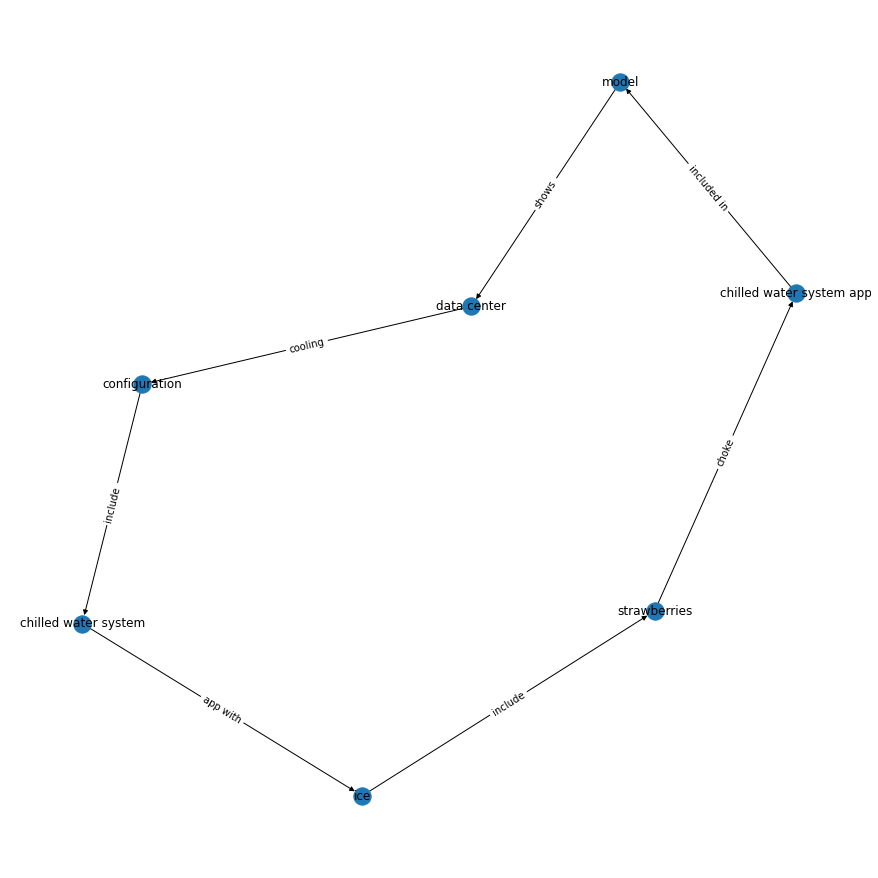

In [156]:
G = nx.from_pandas_edgelist(df, "source", "target",
                            edge_attr=True, create_using=nx.MultiDiGraph())
plt.figure(figsize=(12, 12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, pos=pos)

# Add edge labels
edge_labels = {(row['source'], row['target']): row['edge']
               for _, row in df.iterrows()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.show()


In [167]:
print(cleanNshort)
doc=nlp(cleanNshort)
# displacy.render(doc, style="dep")
noun_chunks = get_noun_chunks(doc, remove_list, exclude_list)
predicates, sources, targets = get_predicates_between_noun_chunks(
    doc, noun_chunks)

displacy.render({'text': cleanNshort, 'ents': noun_chunks + predicates,
                'title': None}, style='ent', manual=True, jupyter=True, options={'colors': {"PRED": funkycolor}})


s a temperature of Tchr.
The model of the air loop shown in FIG. 2 depicts air flow in the data center. The air loop in a chilled water cooling scheme in the example shown in FIG. 2 includes the interaction of air streams with the CRAH mass, the plenum, IT equipment, the room, walls, floor, and ceiling. 
Air from the cooler having a temperature of Tsa is introduced to the plenum and mixes with air in the plenum to form air having a temperature of Tp. Air from the plenum having temperature Tp passes through perforated floor tiles (and various leakage paths) into the room as air a. Air from the plenum having temperature Tp (and labeled 140b in FIG. 2) also mixes with air from the room having a temperature of Trm, to form air having temperature TITin that enters an inlet of IT equipment, which includes all IT equipment (and is positioned in the room), such as servers positioned in equipment racks, and may also be referred to herein as an "equipment rack" or simply "rack." Air which flows 

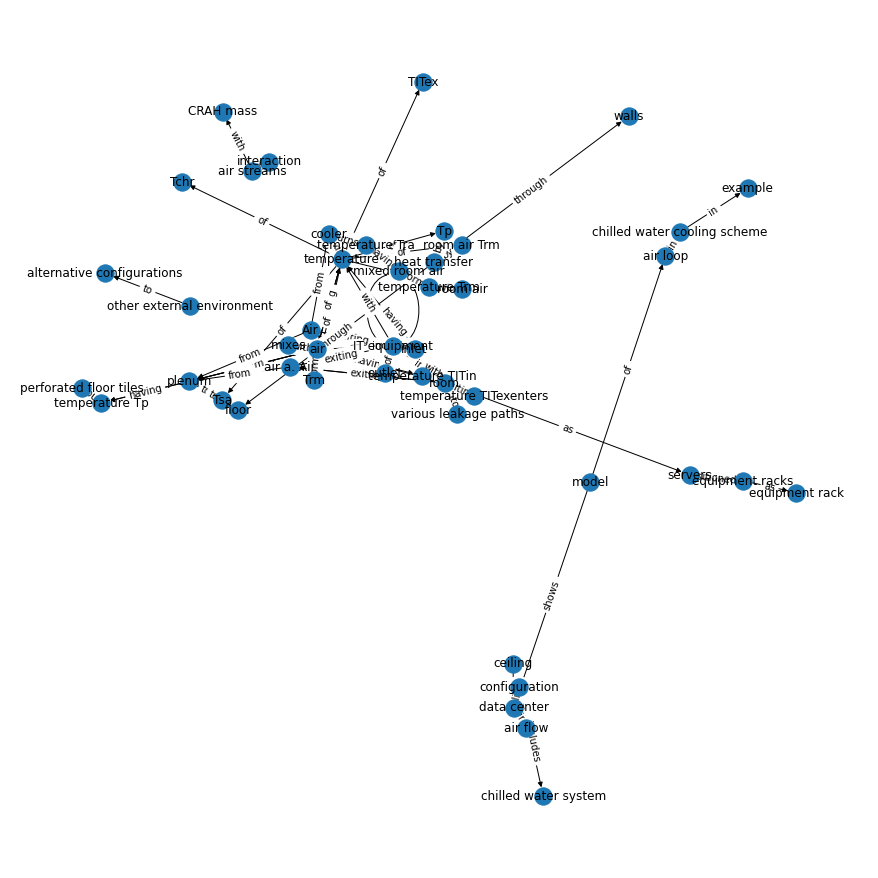

In [159]:
df = pd.DataFrame({'source': [str(s) for s in sources], 
                    'target': [str(t) for t in targets], 
                    'edge': [r['text'] for r in predicates]})

G = nx.from_pandas_edgelist(df, "source", "target",
                            edge_attr=True, create_using=nx.MultiDiGraph())
plt.figure(figsize=(12, 12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, pos=pos)

# Add edge labels
edge_labels = {(row['source'], row['target']): row['edge']
               for _, row in df.iterrows()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.show()


#### find errors

#### ideas
- make a matrix of relations between all NC in a sentence and choose the best ones
- handle coordinations
- ternary relations work?
- better parser: Trankit?
- text preparation to improve results
	- "said"
	- past participles into "that is pp" (no past tense in patents?)
- coreference resolution
- negation
- special treatment for non-connected graphs
- nice inline visualization



### work with Prodigy

goal
- train spacy models for the extraction of relations
- find alternative
- compare

https://support.prodi.gy/t/beta-testers-wanted-new-manual-dependencies-relations-ui-v1-10/2893